# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [44]:
# enrichment assays
assays = {'LWR': 0.043, 'MMR':0.13, 'Xe-100':0.155, 
          'VOYGR':0.0409, 'feed':0.00711,'tails':0.002}

## Scenario 1

In [3]:
def add_receiver_prototype(db_file):
    '''
    Creates dataframe of transactions information, and adds in
    the prototype name corresponding to the ReceiverId of the
    transaction. This dataframe is merged with the Agents dataframe, with the
    AgentId column renamed to ReceivedId to assist the merge process. The
    final dataframe is organized by ascending order of Time then TransactionId

    Parameters:
    -----------
    db_file: str
        SQLite database from Cyclus

    Returns:
    --------
    receiver_prototype: dataframe
        contains all of the transactions with the prototype name of the
        receiver included
    '''
    evaler = tm.get_metrics(db_file)
    agents = evaler.eval('Agents')
    agents = agents.rename(columns={'AgentId': 'ReceiverId'})
    resources = evaler.eval('Resources')
    resources = resources[['SimId', 'ResourceId', 'ObjId', 'TimeCreated',
                           'Quantity', 'Units']]
    resources = resources.rename(columns={'TimeCreated': 'Time'})
    transactions = evaler.eval('Transactions')
    trans_resources = pd.merge(
        transactions, resources, on=[
            'SimId', 'Time', 'ResourceId'], how='inner')
    receiver_prototype = pd.merge(
        trans_resources, agents[['SimId', 'ReceiverId', 'Prototype']], on=[
            'SimId', 'ReceiverId']).sort_values(by=['Time']).reset_index(drop=True)
    return receiver_prototype

def commodity_to_LWR(transactions_df, commodity, prototype):
    '''
    Finds the transactions of a specific commodity sent to the LWRs in the
    simulation, modifies the time column, and adds in zeros for any time step
    without a transaction to the LWRs, and sums all transactions for
    a single time step

    Parameters:
    -----------
    transactions_df: dataframe
        dataframe of transactions with the prototype name
        of the receiver agent added in. use add_receiver_prototype to get this
        dataframe
    commodity: str
        commodity of interest
    prototype: str
        name of non-LWR reactor prototype in the simulation

    Output:
    -------
    prototype_transactions: dataframe
        contains summed transactions at each time step that are sent to
        the specified prototype name.
    '''
    prototype_transactions = tm.find_commodity_transactions(
        transactions_df, commodity)
    prototype_transactions = prototype_transactions[~prototype_transactions['Prototype'].isin(prototype)]
    prototype_transactions = tm.sum_and_add_missing_time(prototype_transactions)
    prototype_transactions = tm.add_year(prototype_transactions)
    return prototype_transactions

In [4]:
s1_outfile = "../outputs/united_states_2020.sqlite"

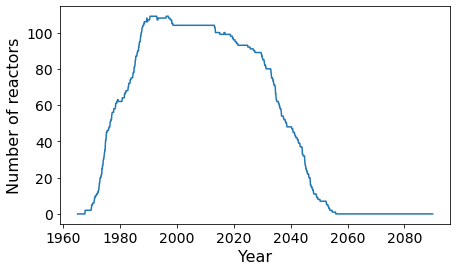

In [4]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.get_lwr_totals(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

plt.figure(figsize=(7,4))
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'])
plt.xlabel('Year', size=16)
plt.ylabel('Number of reactors', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_reactors.pdf')

In [5]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")
s1_lwrs = s1_agents.loc[s1_agents['Spec'] == ':cycamore:Reactor']

In [6]:
print('Total Number of LWRs deployed:', len(s1_lwrs))
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in January 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1095])

Total Number of LWRs deployed: 115
Max LWRs deployed: 109.0
LWRS deployed in January 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
1091             0.0  2055.92
1092             0.0  2056.00
1093             0.0  2056.08
1094             0.0  2056.17


In [7]:
#energy
s1_energy = tm.get_annual_electricity(s1_outfile)
s1_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.042667
58,2025,89.456500
59,2026,88.280583


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

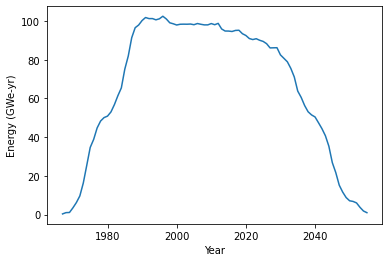

In [8]:
plt.plot(s1_energy['Year'], s1_energy['Energy'])
plt.xlabel('Year')
plt.ylabel('Energy (GWe-yr)')
plt.savefig('figures/s1_energy.pdf')

In [9]:
s1_transactions = add_receiver_prototype(s1_outfile)

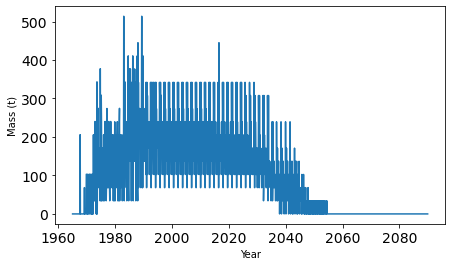

In [15]:
#Uranium resources sent to reactors
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.figure(figsize=(7,4))
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
plt.ylabel('Mass (t)')
plt.xlabel('Year')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_uox.pdf')

In [16]:
print(s1_uox['Quantity'].max())
print(s1_uox['Quantity'].mean())
print(s1_uox['Quantity'][721:1089].mean())

513717.84232364414
95653.23651452248
81110.40952552758


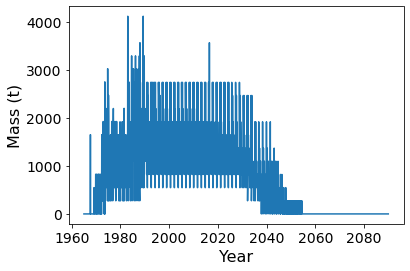

In [17]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], assays['LWR'], assays['tails'], assays['feed'])
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf')

In [18]:
print(s1_feed.max())
print(s1_feed.mean())
print(s1_feed[721:1089].mean())

4121806.5626750314
767472.1520734677
650788.0216333915


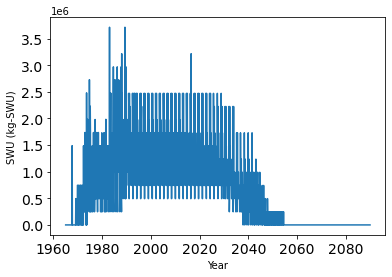

In [19]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], assays['LWR'], s1_tails, 
                          assays['tails'], s1_feed, assays['feed'])
plt.plot(s1_uox["Year"], s1_swu)
plt.xlabel('Year')
plt.ylabel('SWU (kg-SWU)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf')

In [20]:
print(s1_swu.max())
print(s1_swu.mean())
print(s1_swu[721:1089].mean())

3714166.4210974053
691570.3716354567
586426.1169098741


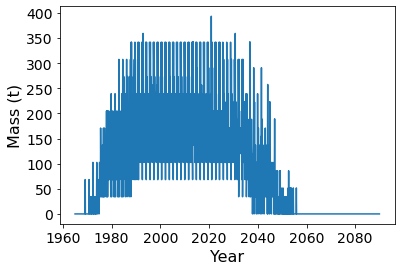

In [21]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf')

In [22]:
print(s1_waste['Quantity'].max())
print(s1_waste['Quantity'].mean())
print(s1_waste['Quantity'][721:1089].mean())

393622.40663899935
91721.28630705364
93898.30642251472


## No growth scenarios

In [4]:
out_files = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

In [5]:
# Reactor Deployment Constants
non_lwr = ['Sink_HLW', 'Sink_LLW', 'Mine',
                 'Enrichment', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR', 'Xe-100','VOYGR', 'Xe-100CoolingPool',
                 'MMRCoolingPool', 'VOYGRCoolingPool']

adv_rxs = ['MMR', 'Xe-100', 'VOYGR']

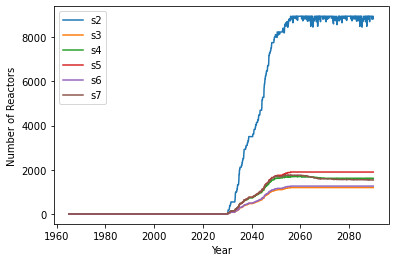

In [54]:
reactors = {'s2_reactors':"",
            's3_reactors':"",
            's4_reactors':"",
            's5_reactors':"",
            's6_reactors':"",
            's7_reactors':""}
for key in reactors:
    scenario = key[:2]
    reactors[key] = tm.get_prototype_totals(out_files[scenario+'_outfile'], non_lwr, adv_rxs)
    plt.plot(reactors[key]['Year'], reactors[key]['advrx_total'], label=scenario)
plt.xlabel('Year')
plt.ylabel('Number of Reactors')
plt.legend()
plt.savefig('figures/nogrowth_reactors.png', bbox_inches='tight')

In [55]:
for key in reactors:
    scenario = key[1]
    for adv_rx in adv_rxs:
        print(f'Max {adv_rx} in S{scenario}:', reactors[key][adv_rx +'_total'].max())
        print(f'Max {adv_rx} added in one step in S{scenario}:', reactors[key][adv_rx +'_enter'].max())
        prototype_sum = reactors[key][adv_rx +'_enter'].cumsum()
        print(f'Total number of {adv_rx} deployed in S{scenario};', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{scenario}:', reactors[key]['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{scenario}:', reactors[key]['advrx_enter'].max())
    advrx_sum = reactors[key]['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{scenario}:', advrx_sum.iloc[-1])  

Max MMR in S2: 8946.0
Max MMR added in one step in S2: 378.0
Total number of MMR deployed in S2; 25887.0
Max Xe-100 in S2: 0.0
Max Xe-100 added in one step in S2: 0.0
Total number of Xe-100 deployed in S2; 0.0
Max VOYGR in S2: 0.0
Max VOYGR added in one step in S2: 0.0
Total number of VOYGR deployed in S2; 0.0
Max Adv Rx in S2: 8946.0
Max Adv Rx added in one step in S2: 378.0
Total number of reactors deployed in S2: 25887.0
Max MMR in S3: 0.0
Max MMR added in one step in S3: 0.0
Total number of MMR deployed in S3; 0.0
Max Xe-100 in S3: 1193.0
Max Xe-100 added in one step in S3: 50.0
Total number of Xe-100 deployed in S3; 1193.0
Max VOYGR in S3: 0.0
Max VOYGR added in one step in S3: 0.0
Total number of VOYGR deployed in S3; 0.0
Max Adv Rx in S3: 1193.0
Max Adv Rx added in one step in S3: 50.0
Total number of reactors deployed in S3: 1193.0
Max MMR in S4: 623.0
Max MMR added in one step in S4: 26.0
Total number of MMR deployed in S4; 1587.0
Max Xe-100 in S4: 1128.0
Max Xe-100 added in o

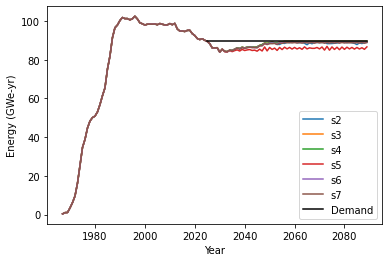

In [57]:
# Energy
energy = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy:
    scenario = key[:2]
    energy[key] = tm.get_annual_electricity(out_files[scenario + '_outfile'])
    plt.plot(energy[key]['Year'], energy[key]['Energy'], label=scenario)
plt.plot(np.linspace(2025,2089,65), np.repeat(89.45655, 65), 'k', label='Demand')
plt.xlabel('Year')
plt.ylabel('Energy (GWe-yr)')
plt.legend()
plt.savefig('figures/nogrowth_energy.pdf')

In [6]:
# Fuel mass
transactions = {'s2':'', 's3':'', 's4':'','s5':'', 's6':'','s7':''}
total_fuel = {'s2_fuel':'', 's3_fuel':'', 's4_fuel':'',
             's5_fuel':'', 's6_fuel':'', 's7_fuel':''}
for key in total_fuel:
    scenario = key[:2]
    transactions[scenario] = add_receiver_prototype(out_files[scenario + '_outfile'])
    fuel = tm.commodity_mass_traded(transactions[scenario], 'fresh_uox')
    total_fuel[key] = tm.add_year(fuel)

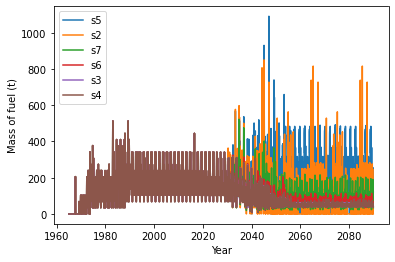

In [7]:
plotting_order = ['s5_fuel', 's2_fuel', 's7_fuel', 's6_fuel','s3_fuel', 's4_fuel']
for key in plotting_order: 
    scenario = key[:2]
    plt.plot(total_fuel[key]['Year'], total_fuel[key]['Quantity']/1000, label=scenario)
plt.xlabel('Year')
plt.ylabel('Mass of fuel (t)')
plt.legend()
plt.savefig('figures/nogrowth_fuel.pdf')

In [8]:
# Mass fraction of uranium in fuel for each type of reactor
uranium_fractions = {'LWR':1, 'MMR':0.8857, 'Xe-100':0.895285, 'VOYGR':0.881427}

In [45]:
#Dividing fuel mass by prototype
fuel_to_reactors = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':'',}
for key in uranium_to_reactors:
    scenario = key[:2]
    reactor = key[3:]
    if reactor == 'LWR':
        fuel_to_reactors[key] = commodity_to_LWR(transactions[scenario], 
                                                        'fresh_uox', adv_rxs)
    else: 
        fuel_to_reactors[key] = tm.commodity_to_prototype(transactions[scenario], 
                                                        'fresh_uox', reactor)

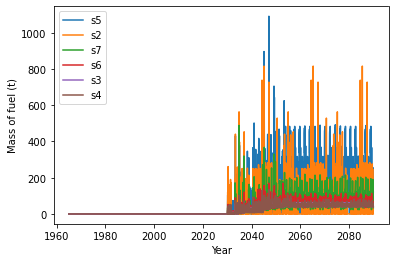

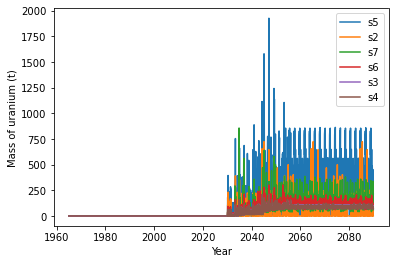

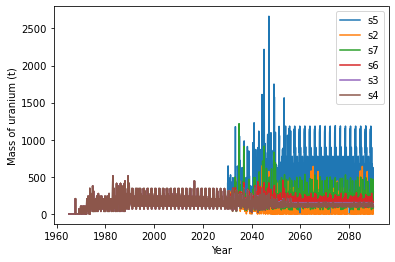

In [47]:
for key in ['s5','s2','s7','s6','s3','s4']:
    scenario = key[:2]
    
    plt.figure(0)
    AR_fuel = fuel_to_reactors[scenario + '_MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_fuel['Quantity'] += fuel_to_reactors[scenario+'_'+reactor]['Quantity']
    plt.plot(AR_fuel['Year'], AR_fuel['Quantity']/1000, label=scenario)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Mass of fuel (t)')
    plt.savefig('figures/nogorwth_AR_fuel.pdf')
    
    plt.figure(1)
    AR_uranium = fuel_to_reactors[scenario + '_MMR']
    AR_uranium['Quantity'] = AR_uranium['Quantity']*uranium_fractions['MMR']
    for reactor in ['Xe-100', 'VOYGR']:
        AR_uranium['Quantity'] += fuel_to_reactors[scenario+'_'+reactor]['Quantity']*uranium_fractions[reactor]
    plt.plot(AR_uranium['Year'], AR_uranium['Quantity']/1000, label=scenario)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Mass of uranium (t)')
    plt.savefig('figures/nogrowth_AR_uranium.pdf')
    
    plt.figure(2)
    total_uranium = fuel_to_reactors[scenario + '_MMR']
    total_uranium['Quantity'] = total_uranium['Quantity']*uranium_fractions['MMR']
    for reactor in ['Xe-100', 'VOYGR', 'LWR']:
        total_uranium['Quantity'] += fuel_to_reactors[scenario+'_'+reactor]['Quantity']*uranium_fractions[reactor]
    plt.plot(total_uranium['Year'], total_uranium['Quantity']/1000, label=scenario)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Mass of uranium (t)')
    plt.savefig('figures/nogrowth_uranium.pdf')

In [64]:
#SWU Calculations
tails = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
feed = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
SWU = {'s2_MMR':'', 's2_Xe-100':'', 's2_VOYGR':'', 's2_LWR':'',
                       's3_MMR':'', 's3_Xe-100':'', 's3_VOYGR':'', 's3_LWR':'',
                       's4_MMR':'', 's4_Xe-100':'', 's4_VOYGR':'', 's4_LWR':'',
                       's5_MMR':'', 's5_Xe-100':'', 's5_VOYGR':'', 's5_LWR':'',
                       's6_MMR':'', 's6_Xe-100':'', 's6_VOYGR':'', 's6_LWR':'',
                       's7_MMR':'', 's7_Xe-100':'', 's7_VOYGR':'', 's7_LWR':''}
for key in feed:
    scenario = key[:2]
    reactor = key[3:]
    tails[key] = tm.calculate_tails(fuel_to_reactors[key]['Quantity']*uranium_fractions[reactor], 
                                    assays[reactor], assays['tails'], assays['feed'])
    feed[key] = tm.calculate_feed(fuel_to_reactors[key]['Quantity']*uranium_fractions[reactor], tails[key])
    SWU[key] = tm.calculate_SWU(fuel_to_reactors[key]['Quantity']*uranium_fractions[reactor],
                                assays[reactor], tails[key], assays['tails'],
                                feed[key], assays['feed'])

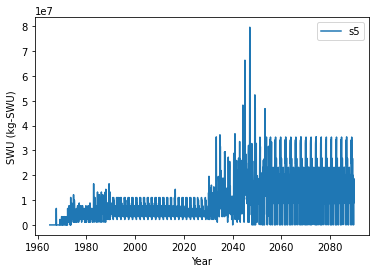

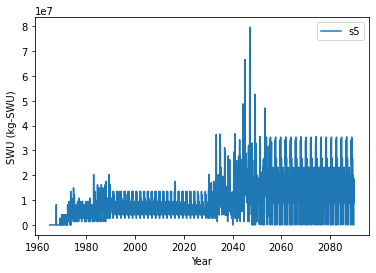

In [66]:
for key in ['s5']:
    SWU_total = SWU[key+'_MMR']
    for reactor in ['Xe-100','VOYGR']:
        SWU_total += SWU[key + '_' + reactor]
    plt.figure(0)
    plt.plot(fuel_to_reactors[key + '_MMR']['Year'], SWU_total, label=key)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('SWU (kg-SWU)')
    plt.savefig('figures/nogrowth_AR_SWU.pdf')
    
    plt.figure(1)
    SWU_total += SWU[key +'_LWR']
    plt.plot(fuel_to_reactors[key + '_MMR']['Year'], SWU_total, label=key)
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('SWU (kg-SWU)')
    plt.savefig('figures/nogrowth_SWU.pdf')

In [57]:
SWU[key]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1495    0.0
1496    0.0
1497    0.0
1498    0.0
1499    0.0
Name: Quantity, Length: 1500, dtype: float64